# Lista 06 - Classificação Binária

>Yanna Torres Gonçalves
>
>Matrícula: 587299
>
>Mestrado em Ciências da Computação


## Parte 01: limpeza e pré-processamento dos dados

In [3]:
!pip install faiss-gpu-cu12
!pip install scikit-learn fuzzywuzzy python-Levenshtein spacy nltk sentence_transformers emoji unidecode

  Using cached faiss_gpu_cu12-1.11.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached faiss_gpu_cu12-1.11.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.0 MB)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached python_levenshtein-0.27.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached spacy-3.8.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached emoji-2.14.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached Unidecode-1.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached levenshtein-0.27.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.6 kB)
  Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.wh

In [4]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
import pandas as pd
import numpy as np
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import spacy
from tqdm import tqdm
tqdm.pandas()

nltk.download('punkt')
nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### a) Ler o dataset fakeTelegram.BR_2022.csv

Utilizamos o mesmo dataset da lista 01, acessando pelo mesmo link.

[https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv](https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv)
   

In [ ]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [ ]:
df.describe()

### b) Remova os trava-zaps, as linhas repetidas e textos com menos de 5 palavras

#### Removendo os trava-zaps

In [ ]:
def has_trava_zap(message):
    if not isinstance(message, str):
        return False  # Garante que só analisa strings

    # Regra 1: muito longo
    if len(message) > 10000:
        return True

    # Regra 2: caracteres invisíveis
    invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
    if sum(message.count(c) for c in invisible) > 100:
        return True

    # Regra 3: emojis repetidos
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(message)
    if any(len(e) > 20 for e in emojis):
        return True

    # Regra 4: baixa diversidade
    unique = set(message)
    if len(unique) < 10 and len(message) > 500:
        return True

    return False

In [ ]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)

In [ ]:
df_clean = df[df['trava_zap'] == False]

In [ ]:
df_clean.drop(columns=['trava_zap'], inplace=True)

In [ ]:
df_clean.describe()

#### Removendo as linhas repetidas

In [ ]:
df_clean = df_clean.drop_duplicates()

In [ ]:
df_clean.describe()

#### Removendo textos com menos de 5 palavras

In [ ]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

In [ ]:
df_clean.describe()

### c) Agrupe as linhas com postagens iguais ou semelhantes

In [ ]:
df_clean.columns

In [ ]:
import emoji
import unidecode

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = emoji.replace_emoji(text, " ")
    text = re.sub(r"[^\w\sÀ-ÿ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df_clean['text_normalized'] = df_clean['text_content_anonymous'].progress_apply(normalize_text)

In [ ]:
df_clean = df_clean[df_clean['text_normalized'].notnull()]
df_clean = df_clean[df_clean['text_normalized'] != ""]

In [ ]:
len(df_clean)

In [ ]:
df_clean = df_clean[df_clean['text_normalized'].str.split().str.len() >= 5]

In [ ]:
len(df_clean)

In [ ]:
# Remove exact duplicates and count occurrences as "shares"
df_grouped = (
    df_clean.groupby('text_normalized', as_index=False)
      .agg({
            'date_message': 'min',
            'id_member_anonymous': 'first',
            **{col: 'first' for col in df_clean.columns if col != 'text_normalized' and col != 'date_message'}
      })
)

In [ ]:
share_counts = df_clean['text_content_anonymous'].value_counts().to_dict()
df_grouped['shares'] = df_grouped['text_content_anonymous'].map(share_counts)

In [ ]:
len(df_grouped)

In [ ]:
df_grouped.head(5)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Load a multilingual model (Portuguese-friendly) and move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)

In [ ]:
# Get embeddings (batch-processed on GPU)
texts = df_grouped['text_normalized'].tolist()
print("Encoding texts into embeddings...")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, device=device)
df_grouped['embedding'] = embeddings.tolist()

In [ ]:
df_grouped = df_grouped.reset_index(drop=True)
embeddings_array = np.array(df_grouped['embedding'].tolist())

In [ ]:
import faiss

faiss.normalize_L2(embeddings)
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

In [ ]:
from collections import defaultdict

similarity_threshold = 0.9
k = 1000

clusters = defaultdict(list)
removed_indices = set()

for i in tqdm(range(len(df_grouped))):
    if i in removed_indices:
        continue
    vec = embeddings[i].reshape(1, -1)
    D, I = index.search(vec, k)
    for sim, j in zip(D[0][1:], I[0][1:]):
        if j == -1 or j == i or j in removed_indices:
            continue
        if sim >= similarity_threshold:
            clusters[i].append(j)
            removed_indices.add(j)

In [ ]:
results = []
used = set()

for base_idx, sim_indices in tqdm(clusters.items()):
    if base_idx in used:
        continue
    total_count = df_grouped.iloc[base_idx]['shares']
    used.add(base_idx)
    for sim_idx in sim_indices:
        total_count += df_grouped.iloc[sim_idx]['shares']
        used.add(sim_idx)
    row = df_grouped.iloc[base_idx].copy()
    row['shares'] = total_count
    results.append(row)

# Add remaining unmatched
remaining = df_grouped.loc[~df_grouped.index.isin(used)].copy()
final_df = pd.concat([pd.DataFrame(results), remaining], ignore_index=True)

In [ ]:
len(final_df)

In [ ]:
final_df.head()

In [ ]:
final_df.drop(columns=['embedding']).to_csv("grouped_by_similarity.csv")

In [ ]:
final_df[['text_content_anonymous', 'shares']].sort_values(by='shares', ascending=False).head(10)

In [ ]:
final_df[['text_normalized', 'text_content_anonymous', 'shares']].sort_values(by='shares', ascending=False).head(10)

---

### d) Colunas Auxiliares

Para facilitar a recuperação de dados em alguns casos, vamos criar colunas auxiliares.

In [ ]:
import regex

def is_latin_only(text):
    # This keeps only rows that are entirely Latin script (with punctuation, digits, spaces)
    return bool(regex.fullmatch(r'[\p{Latin}\d\s\p{P}\p{S}]+', str(text)))

cleaned_df = final_df[final_df['text_normalized'].apply(is_latin_only)]

In [ ]:
len(cleaned_df)

In [ ]:
stop_words = set(stopwords.words('portuguese', 'english'))

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text_no_punct)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)

cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)

In [ ]:
cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notnull(x) else 0)

In [ ]:
def classify_misinformation(score):
    if score >= 0.66:
        return 'Misinformation'
    elif score >= 0.33:
        return 'Neutral'
    else:
        return 'Non-misinformation'

# Criar coluna de categoria
cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)

In [ ]:
cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))

In [ ]:
cleaned_df.info()

In [ ]:
cleaned_df.describe()

In [ ]:
cleaned_df.drop(columns=['embedding']).to_csv("grouped_cleaned.csv")

## Parte 02: Modelo Preditivo (Classificador Binário)

Utilizando os dados referente a postagens no Telegram, crie um modelo preditivo
(classificador binário) para classificar uma mensagem em duas classes possíveis: “viral”
(classe positiva) ou “não viral” (classe negativa).

Para rotular as mensagens únicas (agrupadas) nas classes, “viral” e “não viral”,
utilize a seguinte estratégia: Calcule um limiar (threshold).

Por exemplo, mediana do número de compartilhamentos mais dois desvios
padrões. As mensagens com quantidade de compartilhamentos maiores ou iguais ao limiar
definido devem ser rotuladas como “virais”.

As demais mensagens devem ser rotuladas
como “não virais”.

### Pré-processamento

In [7]:
cleaned_df = pd.read_csv("grouped_cleaned.csv")

In [9]:
from sentence_transformers import SentenceTransformer
import torch

# Load a multilingual model (Portuguese-friendly) and move to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)


texts = cleaned_df['text_normalized'].tolist()
print("Encoding texts into embeddings...")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, device=device)
cleaned_df['embedding'] = embeddings.tolist()

2025-07-10 15:06:11.245475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-10 15:06:11.245552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-10 15:06:11.247061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-10 15:06:11.255384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda
Encoding texts into embeddings...


Batches:   0%|          | 0/2767 [00:00<?, ?it/s]

Removendo mensagens com caracteres 

In [10]:
cleaned_df.columns

Index(['Unnamed: 0', 'text_normalized', 'date_message', 'id_member_anonymous',
       'id_group_anonymous', 'media', 'media_type', 'media_url', 'has_media',
       'has_media_url', 'text_content_anonymous', 'dataset_info_id',
       'date_system', 'score_sentiment', 'score_misinformation', 'id_message',
       'message_type', 'messenger', 'media_name', 'media_md5', 'shares',
       'text_no_stopwords', 'word_count', 'character_count',
       'misinformation_category', 'sentiment_category', 'embedding'],
      dtype='object')

In [11]:
len(cleaned_df)

177088

In [12]:
cleaned_df[["shares", "text_content_anonymous"]].sort_values(by='shares', ascending=False).head(40)

,shares,text_content_anonymous
5063,17423,Grupo a diretoria bloqueado:\n\nEstá comunidad...
2617,1607,Comentarios de Anderson Martinho de 29 años. B...
46,1425,"1, pressione o botão abaixo dentro de 3 Minuto..."
9249,1282,"Welcome, 00\n\n🔸 [USER] — professional tool fo..."
7052,1256,Olá 1...2...3...5...8...13...21...34...55...89...
7122,1090,🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...
7055,724,Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...
4551,698,"Feedback de Afonso Rico 27 ​​anos. Brasil, Li..."
9274,627,"Welcome, A MARCOLINO Maranata\n\n🔸 [USER] — pr..."
2152,534,"Bom ter você por aqui, 1. 🇧🇷\n\nConsulte as me..."


In [13]:
len(cleaned_df[cleaned_df['text_normalized'].str.split().str.len() < 5])

0

In [14]:
print(len(cleaned_df[cleaned_df['shares'] > 200]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 200]))

30


177058


In [15]:
print(len(cleaned_df[cleaned_df['shares'] > 100]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 100]))

76


177012


In [16]:
print(len(cleaned_df[cleaned_df['shares'] > 75]))
print("\n")
print(len(cleaned_df[cleaned_df['shares'] <= 75]))

103


176985


In [17]:
cleaned_df = cleaned_df[cleaned_df['shares'] <= 100]

### Features

In [18]:
limiar = cleaned_df["shares"].median() + 2 * cleaned_df["shares"].std()
cleaned_df["is_viral"] = (cleaned_df["shares"] >= limiar).astype(int)  # 1 = viral, 0 = não viral

In [19]:
cleaned_df[["shares", "text_content_anonymous", "is_viral"]].sort_values(by='shares', ascending=False).head()

,shares,text_content_anonymous,is_viral
4196,100,Estou muito feliz com esta plataforma Fiz um i...,1
148,99,🇧🇷 2º Turno - Compartilhe 🇧🇷\n\nLista atualiza...,1
2659,97,.COMO COMEÇAR\n\n 1. Prepare seus fundos.\n\n...,1
8306,97,Seja bem vindo ao grupo 3rr0 📚 Este grupo é li...,1
2465,96,*CDBr INFORMA:*\n\n*VAMOS MOSTRAR AOS PETRALHA...,1


In [20]:
cleaned_df["date_message"] = pd.to_datetime(cleaned_df["date_message"])
cleaned_df["hour"] = cleaned_df["date_message"].dt.hour
cleaned_df["day_of_week"] = cleaned_df["date_message"].dt.dayofweek

In [21]:
from sklearn.preprocessing import LabelEncoder

for col in ["media_type", "sentiment_category", "misinformation_category"]:
    cleaned_df[col] = cleaned_df[col].fillna("unknown")
    cleaned_df[col] = LabelEncoder().fit_transform(cleaned_df[col])

In [22]:
feature_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation",
    "has_media", "sentiment_category", "misinformation_category",
    "hour", "day_of_week"
]

In [23]:
cleaned_null_df = cleaned_df.dropna(subset=feature_cols)

In [24]:
cleaned_null_df.isnull().sum()

Unnamed: 0                     0
text_normalized                0
date_message                   0
id_member_anonymous        47645
id_group_anonymous             0
media                      62237
media_type                     0
media_url                  66633
has_media                      0
has_media_url                  0
text_content_anonymous         0
dataset_info_id                0
date_system                    0
score_sentiment                0
score_misinformation           0
id_message                     0
message_type                   0
messenger                      0
media_name                 82135
media_md5                  62237
shares                         0
text_no_stopwords              0
word_count                     0
character_count                0
misinformation_category        0
sentiment_category             0
embedding                      0
is_viral                       0
hour                           0
day_of_week                    0
dtype: int

In [25]:
embedding_matrix = np.vstack(cleaned_null_df["embedding"])

In [26]:
X_base = cleaned_null_df[feature_cols].values
X = np.hstack([X_base, embedding_matrix])
y = cleaned_null_df["is_viral"]

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

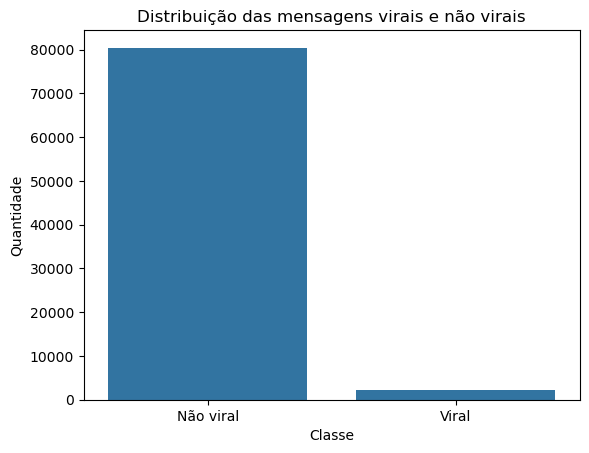

In [28]:
sns.countplot(x="is_viral", data=cleaned_null_df)
plt.title("Distribuição das mensagens virais e não virais")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

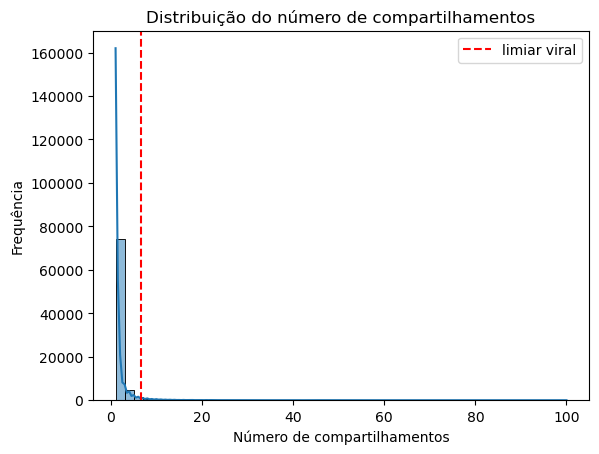

In [29]:
sns.histplot(cleaned_null_df["shares"], bins=50, kde=True)
plt.axvline(limiar, color="red", linestyle="--", label="limiar viral")
plt.title("Distribuição do número de compartilhamentos")
plt.xlabel("Número de compartilhamentos")
plt.ylabel("Frequência")
plt.legend()
plt.show()

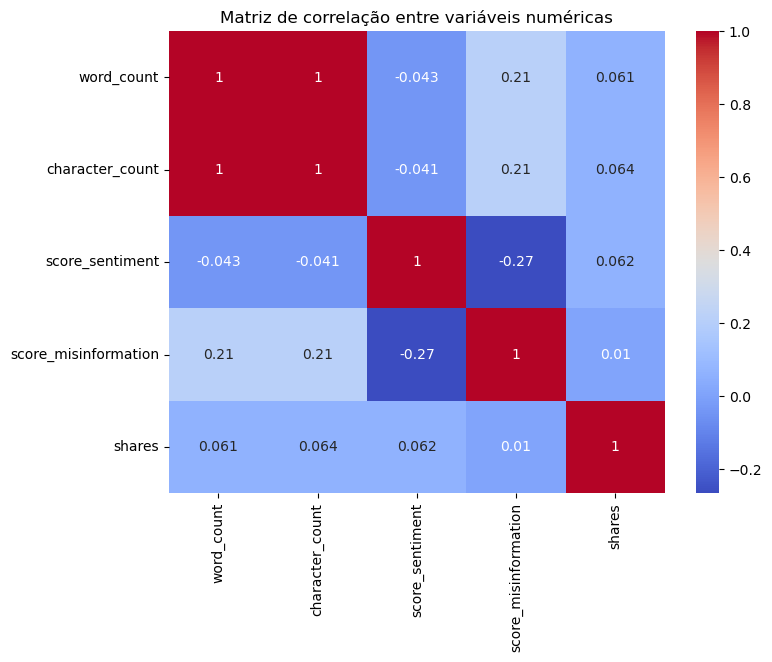

In [30]:
numeric_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation", "shares"
]

corr = cleaned_null_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlação entre variáveis numéricas")
plt.show()

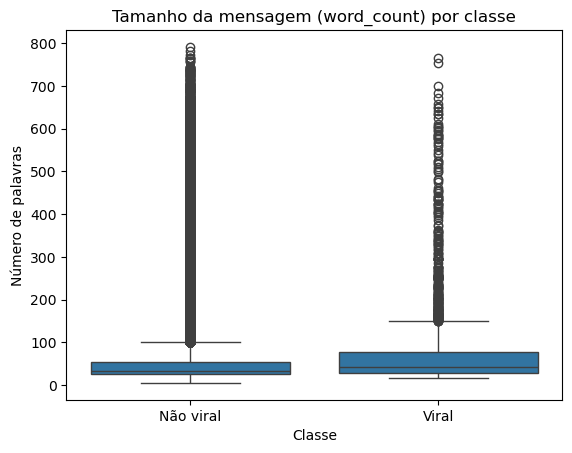

In [31]:
sns.boxplot(x="is_viral", y="word_count", data=cleaned_null_df)
plt.title("Tamanho da mensagem (word_count) por classe")
plt.xlabel("Classe")
plt.ylabel("Número de palavras")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

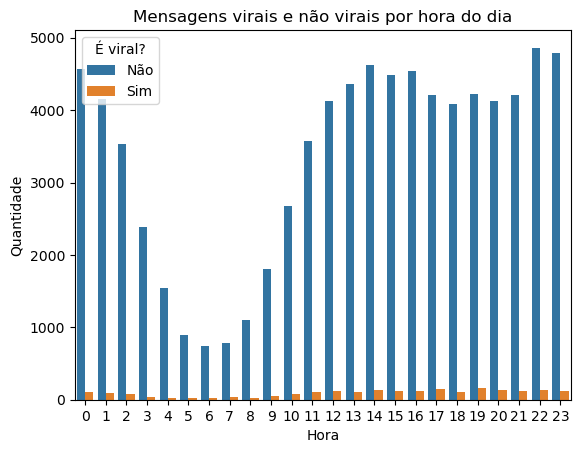

In [32]:
sns.countplot(x="hour", hue="is_viral", data=cleaned_null_df)
plt.title("Mensagens virais e não virais por hora do dia")
plt.xlabel("Hora")
plt.ylabel("Quantidade")
plt.legend(title="É viral?", labels=["Não", "Sim"])
plt.show()

### Training

#### Regressão Logística

In [34]:
!pip install imblearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt

def run_logistic_experiment(
    X, y,
    test_size=0.2,
    balance_strategy=None,         # None, "smote", "ros", "rus"
    normalize=None,                # None, "zscore", "minmax"
    penalty="l2",                  # "none", "l1", "l2", "elasticnet"
    solver="liblinear",            # "liblinear", "saga", etc.
    class_weight=None,             # None, "balanced"
    max_iter=1000,
    l1_ratio=None,                 # only for elasticnet
    verbose=True
):
    print(f"\n🔧 Config: balance={balance_strategy}, normalize={normalize}, penalty={penalty}, weight={class_weight}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=42
    )

    # Normalize
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balance
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=42)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=42)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = None

    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=max_iter,
        l1_ratio=l1_ratio,   # ignored if not elasticnet
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    # Print report
    print("\n📊 Classification Report")
    report_dict = classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não viral", "Viral"], yticklabels=["Não viral", "Viral"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Plot curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[["Não viral", "Viral"], ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.show()

    return report_dict

In [54]:
from sklearn.model_selection import StratifiedKFold

def run_logistic_with_cv(X, y, config, solver, l1_ratio, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"  ➤ Fold {fold_idx+1}/{n_splits}")
        
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        report_dict = run_logistic_experiment(
            X_train, y_train,
            test_size=0.25,  # Optional inner split for train/val
            normalize=config["normalize"],
            balance_strategy=config["balance_strategy"],
            penalty=config["penalty"],
            solver=solver,
            class_weight=config["class_weight"],
            l1_ratio=l1_ratio,
            verbose=False
        )

        fold_scores.append({
            "macro_f1": report_dict["macro avg"]["f1-score"],
            "viral_f1": report_dict["Viral"]["f1-score"]
        })

    return fold_scores


In [45]:
experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "penalty": "none", "class_weight": None},

    # Regularization
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l1", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "elasticnet", "class_weight": None},

    # Normalization variants
    {"normalize": "minmax", "balance_strategy": None, "penalty": "l2", "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": "balanced"},

    # With balancing
    {"normalize": "zscore", "balance_strategy": "smote", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "penalty": "l2", "class_weight": None},
]

##### For SentenceTransformer 


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'none', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=none, weight=None


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



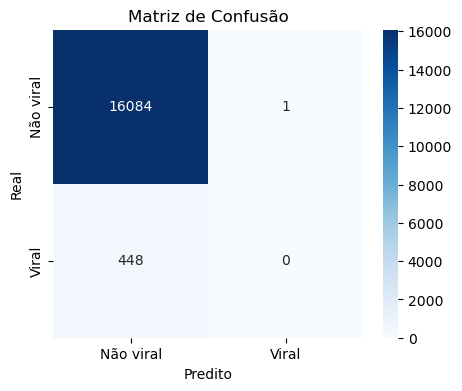

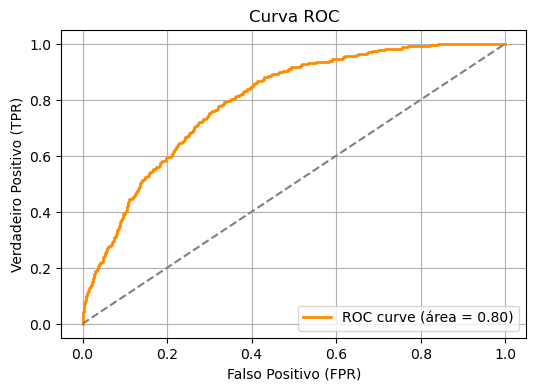

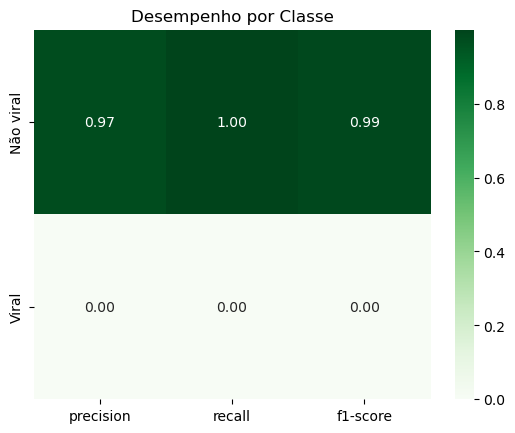


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.67      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.82      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



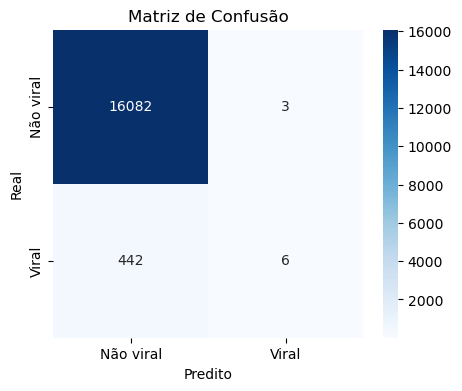

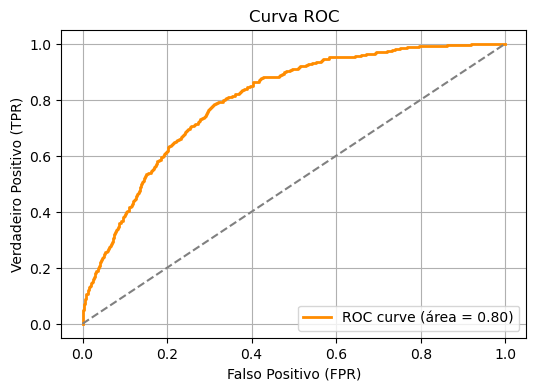

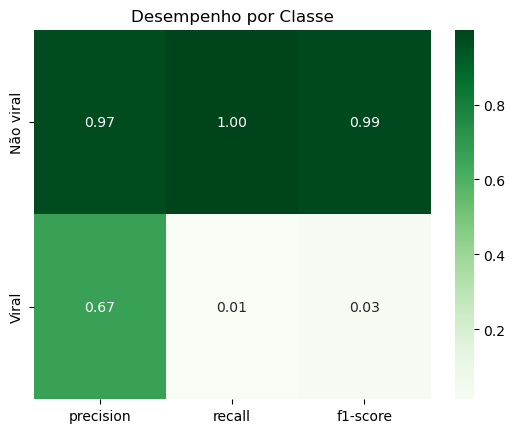


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.54      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.76      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



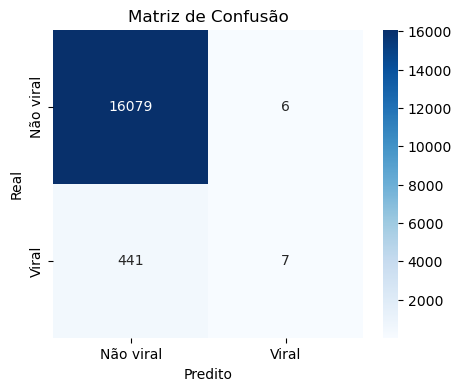

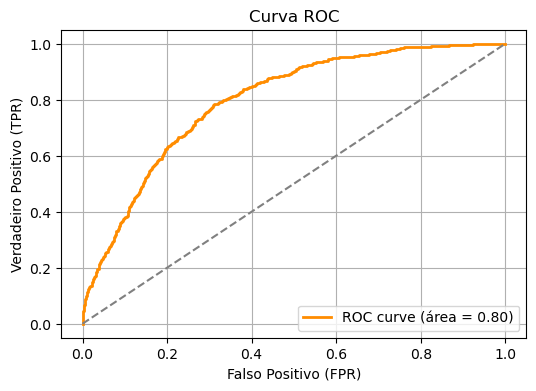

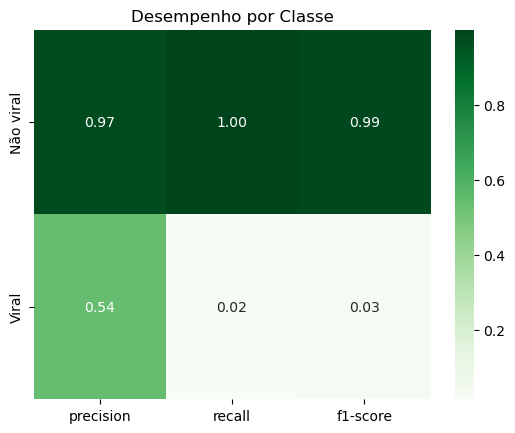


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.70      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.84      0.51      0.51     16533
weighted avg       0.97      0.97      0.96     16533



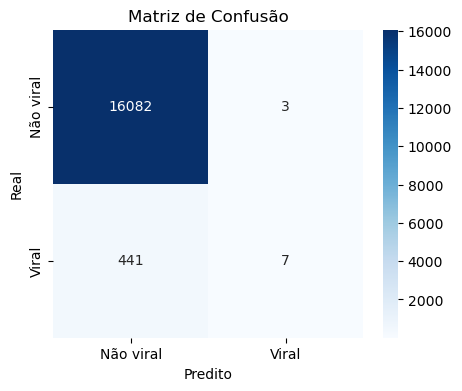

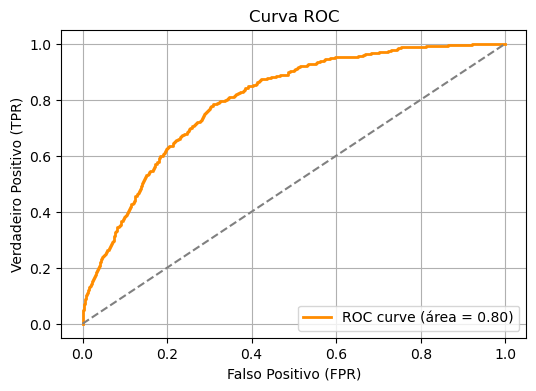

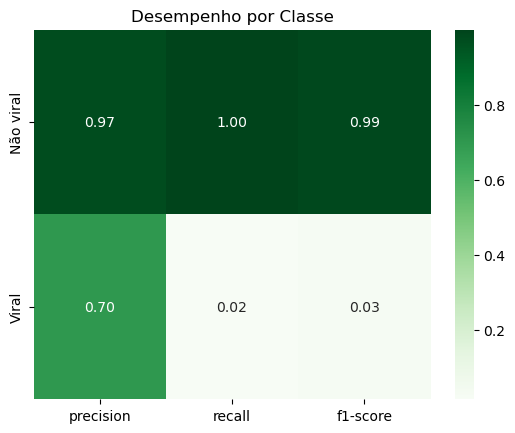


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.74      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



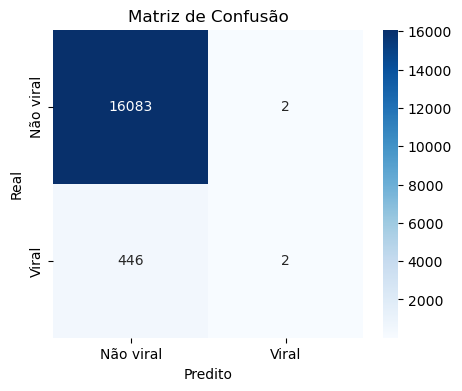

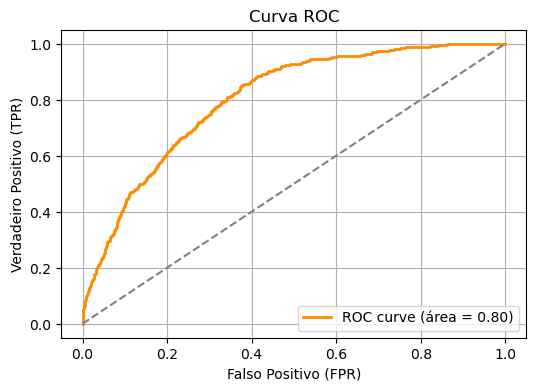

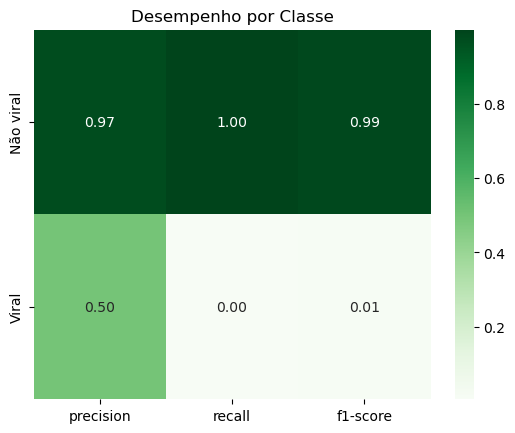


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.74      0.85     16085
       Viral       0.07      0.70      0.13       448

    accuracy                           0.74     16533
   macro avg       0.53      0.72      0.49     16533
weighted avg       0.96      0.74      0.83     16533



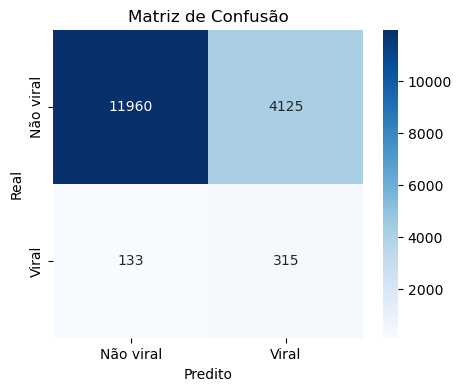

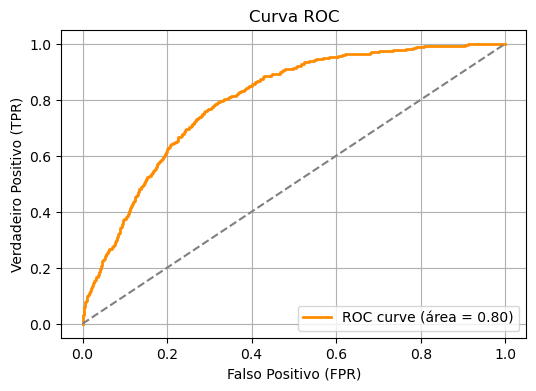

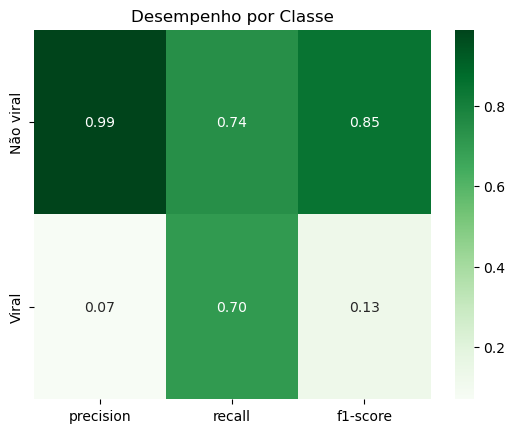


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.77      0.87     16085
       Viral       0.07      0.64      0.13       448

    accuracy                           0.77     16533
   macro avg       0.53      0.71      0.50     16533
weighted avg       0.96      0.77      0.85     16533



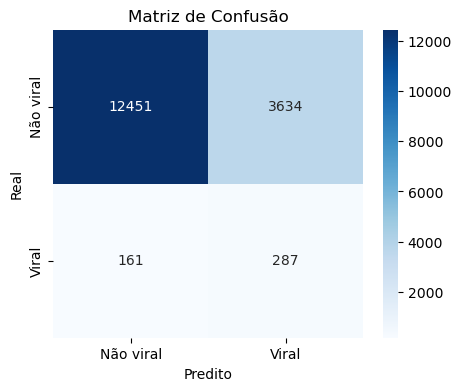

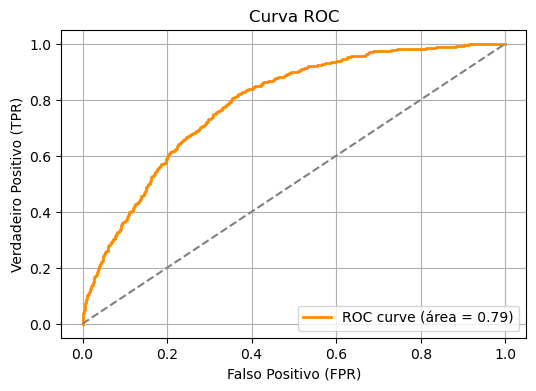

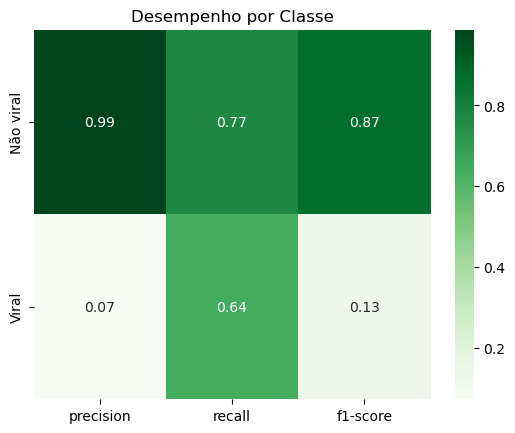


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.74      0.85     16085
       Viral       0.07      0.71      0.13       448

    accuracy                           0.74     16533
   macro avg       0.53      0.72      0.49     16533
weighted avg       0.96      0.74      0.83     16533



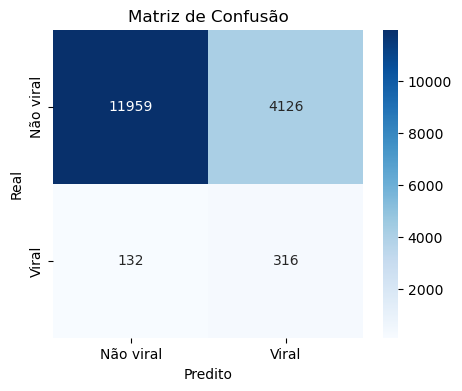

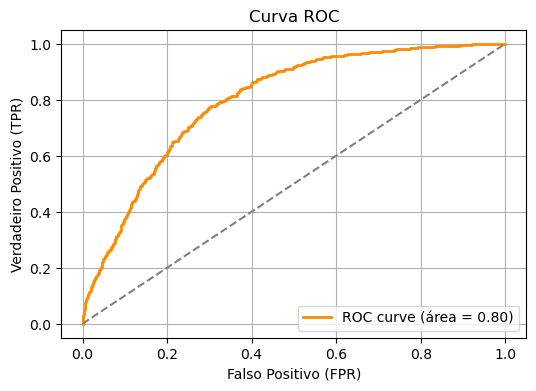

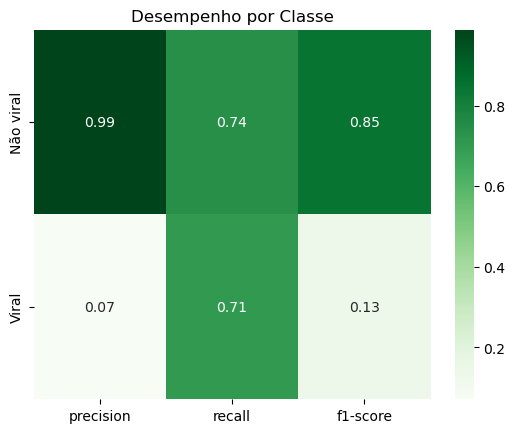


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.72      0.83     16085
       Viral       0.07      0.74      0.12       448

    accuracy                           0.72     16533
   macro avg       0.53      0.73      0.48     16533
weighted avg       0.96      0.72      0.81     16533



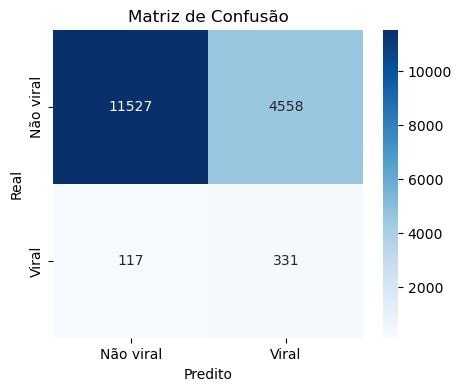

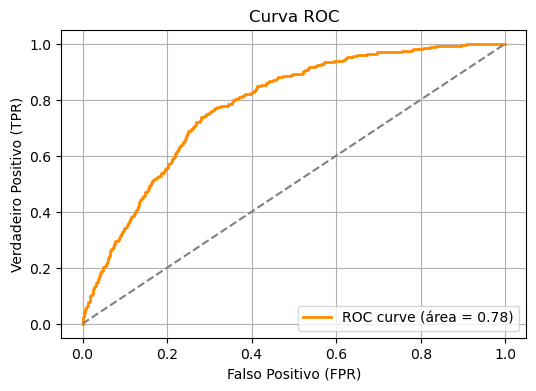

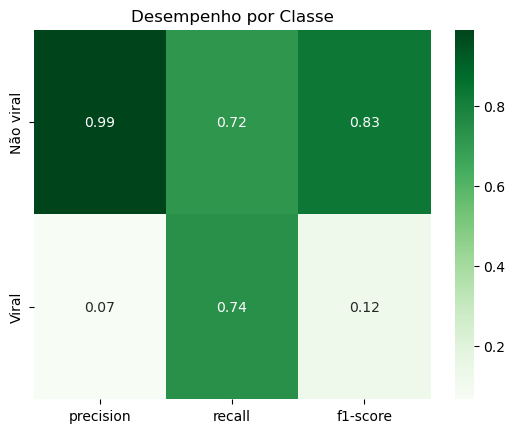

In [57]:
results = []

solver_for_penalty = {
    "none": "lbfgs",
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X, y,
        test_size=0.2,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

#### Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_experiment(
    X, y,
    test_size=0.2,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config DT: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, max_depth={max_depth}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )
    
    # Normalização igual ao run_logistic_experiment
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balanceamento
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    model = DecisionTreeClassifier(
        class_weight=class_weight,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Relatório, matriz de confusão, curva ROC e heatmap similares ao run_logistic_experiment
    # (você pode extrair a parte de avaliação para uma função comum)

    # Exemplo de classification_report
    print("\n📊 Classification Report")
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))

    # Você pode replicar os gráficos que fez para logistic regression aqui

    return classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)


#### Ensemble

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def run_random_forest_experiment(
    X, y,
    test_size=0.2,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    n_estimators=100,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config RF: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, n_estimators={n_estimators}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )
    
    # Normalização e balanceamento idem acima
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    print("\n📊 Classification Report")
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))

    # Você pode replicar os gráficos do logistic regression

    return classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)
